# Import modules and libraries

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
import segmentation_models_3D as sm
import random
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.python.keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


# Custom data loader

In [3]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [4]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


### Define the image generators for training and validation

In [5]:
train_img_dir = "train_val_test/train/images/"
train_mask_dir = "train_val_test/train/masks/"

val_img_dir = "train_val_test/val/images/"
val_mask_dir = "train_val_test/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [22]:
batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


### Loss, metrics and optimizer used for training

In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('train_val_test/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    #print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)
print(wt0,wt1,wt2,wt3)

0.26 22.32 22.32 26.47


In [22]:
#wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

#iou = true_positives / (true_positives + false_positives + false_negatives)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [ ]:
callbacks = [
             keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                                           patience=3, verbose=1, mode='auto'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
             keras.callbacks.ModelCheckpoint(filepath = 'drive/MyDrive/saved_models/vgg16wt/model_.{epoch:02d}-{val_loss:.6f}.h5',
                             verbose=0, save_best_only=True, save_weights_only = True),
             keras.callbacks.CSVLogger('drive/MyDrive/saved_models/vgg16wt/training_log/training_unet.csv', separator=",", append=True)
             ]

# **Train**

Training Parameters

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

#model = resnet_unet(128, 3, 4)
model = vgg16_unet(128, 3, 4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
#print(model.summary())

176619520/176606448 [==============================] - 22s 0us/step


# U-Net model with VGG16 as backbone

In [ ]:
def vgg16_unet(IMG_SIZE, IMG_CHANNELS, n_classes):
    BACKBONE = 'vgg16'
    preprocess_input = sm.get_preprocessing(BACKBONE)   
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE, IMG_CHANNELS),
                    activation=activation, encoder_weights='imagenet', encoder_freeze=False)
    return model

In [ ]:
#Test if everything is working ok. 
model = vgg16_unet(128, 3, 4)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 block1_conv1 (Conv3D)          (None, 128, 128, 12  5248        ['input_1[0][0]']                
                                8, 64)                                                            
                                                                                                  
 block1_conv2 (Conv3D)          (None, 128, 128, 12  110656      ['block1_conv1[0][0]']           
                                8, 64)                                                      

### VGG16 without weights

In [ ]:
history_vgg16_unet=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks
          )

model.save('drive/MyDrive/saved_models/vgg16wowt/resnet34_unet.h5')

Epoch 1/40
120/120 [==============================] - 353s 3s/step - loss: 0.0556 - accuracy: 0.6696 - iou_score: 0.1730 - f1-score: 0.2247 - val_loss: 0.1711 - val_accuracy: 0.5654 - val_iou_score: 0.1494 - val_f1-score: 0.2123 - lr: 1.0000e-04
Epoch 2/40
120/120 [==============================] - 337s 3s/step - loss: -0.1940 - accuracy: 0.7790 - iou_score: 0.2210 - f1-score: 0.2687 - val_loss: 0.2220 - val_accuracy: 0.5276 - val_iou_score: 0.1392 - val_f1-score: 0.2014 - lr: 1.0000e-04
Epoch 3/40
120/120 [==============================] - ETA: 0s - loss: -0.2688 - accuracy: 0.8021 - iou_score: 0.2287 - f1-score: 0.2747
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
120/120 [==============================] - 337s 3s/step - loss: -0.2688 - accuracy: 0.8021 - iou_score: 0.2287 - f1-score: 0.2747 - val_loss: 0.5154 - val_accuracy: 0.5464 - val_iou_score: 0.1282 - val_f1-score: 0.1752 - lr: 1.0000e-04
Epoch 4/40
120/120 [==============================] - 338s

### VGG16 with pretrained weights

In [ ]:
history_vgg16_unet=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks
          )

model.save('drive/MyDrive/saved_models/vgg16wt/vgg16wt.h5')

Epoch 1/40
120/120 [==============================] - 345s 3s/step - loss: 0.1972 - accuracy: 0.5527 - iou_score: 0.1352 - f1-score: 0.1863 - val_loss: 0.0395 - val_accuracy: 0.7442 - val_iou_score: 0.1815 - val_f1-score: 0.2297 - lr: 1.0000e-04
Epoch 2/40
120/120 [==============================] - 340s 3s/step - loss: -0.1033 - accuracy: 0.7838 - iou_score: 0.1998 - f1-score: 0.2435 - val_loss: -0.0737 - val_accuracy: 0.8353 - val_iou_score: 0.2172 - val_f1-score: 0.2538 - lr: 1.0000e-04
Epoch 3/40
120/120 [==============================] - 338s 3s/step - loss: -0.2136 - accuracy: 0.8175 - iou_score: 0.2194 - f1-score: 0.2571 - val_loss: -0.1173 - val_accuracy: 0.8845 - val_iou_score: 0.2354 - val_f1-score: 0.2635 - lr: 1.0000e-04
Epoch 4/40
120/120 [==============================] - 339s 3s/step - loss: -0.2797 - accuracy: 0.8298 - iou_score: 0.2263 - f1-score: 0.2623 - val_loss: -0.1246 - val_accuracy: 0.8753 - val_iou_score: 0.2315 - val_f1-score: 0.2589 - lr: 1.0000e-04
Epoch 5/40

# U-Net model with VGG19 as backbone

In [106]:
def vgg19_unet(IMG_SIZE, IMG_CHANNELS, n_classes):
    BACKBONE = 'vgg19'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE, IMG_CHANNELS),
                    activation=activation, encoder_weights='imagenet', encoder_freeze=True)
    return model

In [96]:
model = vgg19_unet(128, 3, 4)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 block1_conv1 (Conv3D)          (None, 128, 128, 12  5248        ['input_4[0][0]']                
                                8, 64)                                                            
                                                                                                  
 block1_conv2 (Conv3D)          (None, 128, 128, 12  110656      ['block1_conv1[0][0]']           
                                8, 64)                                                      

                                                                  'block5_conv3[0][0]']           
                                                                                                  
 decoder_stage0a_conv (Conv3D)  (None, 8, 8, 8, 256  7077888     ['decoder_stage0_concat[0][0]']  
                                )                                                                 
                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, 8, 8, 8, 256  1024       ['decoder_stage0a_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage0a_relu (Activati  (None, 8, 8, 8, 256  0          ['decoder_stage0a_bn[0][0]']     
 on)                            )                                                                 
          

 decoder_stage3a_relu (Activati  (None, 64, 64, 64,   0          ['decoder_stage3a_bn[0][0]']     
 on)                            32)                                                               
                                                                                                  
 decoder_stage3b_conv (Conv3D)  (None, 64, 64, 64,   27648       ['decoder_stage3a_relu[0][0]']   
                                32)                                                               
                                                                                                  
 decoder_stage3b_bn (BatchNorma  (None, 64, 64, 64,   128        ['decoder_stage3b_conv[0][0]']   
 lization)                      32)                                                               
                                                                                                  
 decoder_stage3b_relu (Activati  (None, 64, 64, 64,   0          ['decoder_stage3b_bn[0][0]']     
 on)      

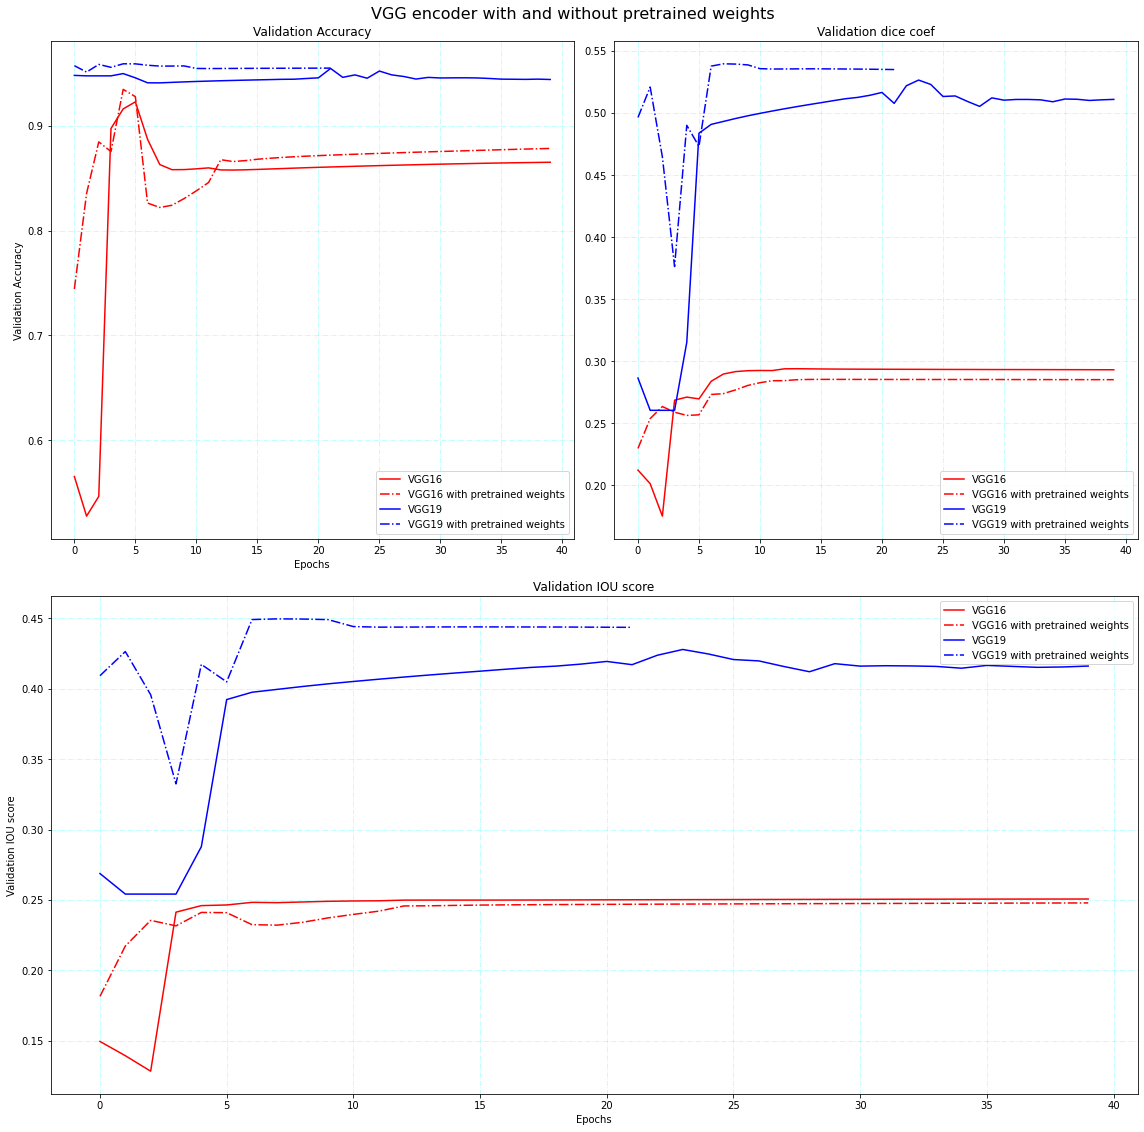

In [2]:
hist_vgg16wowt = pd.read_csv('saved_models/vgg16wowt/training_log/training_unet.csv')
hist_vgg16wt = pd.read_csv('saved_models/vgg16wt/training_log/training_unet.csv')
hist_vgg19wowt = pd.read_csv('saved_models/VGG19wowt/training_log/training_unet.csv')
hist_vgg19wt = pd.read_csv('saved_models/VGG19/training_log/training_unet.csv')

#hist = hist_df
#epoch=range(len(hist_unet_do1))

fig = plt.figure(figsize=(16,16))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.plot(hist_vgg16wowt['val_accuracy'],'r',label='VGG16')
ax1.plot(hist_vgg16wt['val_accuracy'],'-.r',label='VGG16 with pretrained weights')
ax1.plot(hist_vgg19wowt['val_accuracy'],'b',label='VGG19')
ax1.plot(hist_vgg19wt['val_accuracy'],'-.b',label='VGG19 with pretrained weights')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Accuracy')
ax1.legend()

#ax[0,1].plot(hist_vgg16wowt['val_loss'],'r',label='VGG16')
#ax[0,1].plot(hist_vgg16wt['val_loss'],'-.r',label='VGG16 with pretrained weights')
#ax[0,1].plot(hist_vgg19wowt['val_loss'],'b',label='VGG19')
#ax[0,1].plot(hist_vgg19wt['val_loss'],'-.b',label='VGG19 with pretrained weights')
#ax[0,1].set_title('Validation Loss')
#ax[0,1].legend()

ax2.plot(hist_vgg16wowt['val_f1-score'],'r',label='VGG16')
ax2.plot(hist_vgg16wt['val_f1-score'],'-.r',label='VGG16 with pretrained weights')
ax2.plot(hist_vgg19wowt['val_f1-score'],'b',label='VGG19')
ax2.plot(hist_vgg19wt['val_f1-score'],'-.b',label='VGG19 with pretrained weights')
ax2.set_title('Validation dice coef')
ax2.legend()

ax3.plot(hist_vgg16wowt['val_iou_score'],'r',label='VGG16')
ax3.plot(hist_vgg16wt['val_iou_score'],'-.r',label='VGG16 with pretrained weights')
ax3.plot(hist_vgg19wowt['val_iou_score'],'b',label='VGG19')
ax3.plot(hist_vgg19wt['val_iou_score'],'-.b',label='VGG19 with pretrained weights')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Validation IOU score')
ax3.set_title('Validation IOU score')
ax3.legend()


plt.suptitle('VGG encoder with and without pretrained weights', size=16)
ax1.grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax2.grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax3.grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

# U-Net model with ResNet34 as backbone

In [ ]:
def resnet_unet(IMG_SIZE, IMG_CHANNELS, n_classes):
    BACKBONE = 'resnet34'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE, IMG_CHANNELS),
                    activation=activation, encoder_weights='imagenet', encoder_freeze=False)
    return model

In [ ]:
#Test if everything is working ok. 
model = resnet_unet(128, 3, 4)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 12  9           ['data[0][0]']                   
                                8, 3)                                                             
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, 134, 134, 13  0          ['bn_data[0][0]']                
                                4, 3)                                                       

### ResNet34 with batch size 1

In [ ]:
history_resnet34_unet=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks
          )

model.save('drive/MyDrive/saved_models/resnet34wowt/resnet34_unet.h5')


Epoch 1/40
240/240 [==============================] - 227s 824ms/step - loss: 0.7583 - accuracy: 0.8997 - iou_score: 0.2304 - f1-score: 0.2528 - val_loss: 0.7788 - val_accuracy: 0.8927 - val_iou_score: 0.2520 - val_f1-score: 0.2742 - lr: 1.0000e-04
Epoch 2/40
240/240 [==============================] - 196s 818ms/step - loss: 0.7364 - accuracy: 0.9164 - iou_score: 0.2501 - f1-score: 0.2700 - val_loss: 0.7694 - val_accuracy: 0.8531 - val_iou_score: 0.2468 - val_f1-score: 0.2763 - lr: 1.0000e-04
Epoch 3/40
240/240 [==============================] - 196s 816ms/step - loss: 0.7334 - accuracy: 0.9135 - iou_score: 0.2533 - f1-score: 0.2744 - val_loss: 0.7512 - val_accuracy: 0.9320 - val_iou_score: 0.2558 - val_f1-score: 0.2702 - lr: 1.0000e-04
Epoch 4/40
240/240 [==============================] - 194s 808ms/step - loss: 0.7346 - accuracy: 0.9077 - iou_score: 0.2536 - f1-score: 0.2760 - val_loss: 0.7524 - val_accuracy: 0.8937 - val_iou_score: 0.2585 - val_f1-score: 0.2844 - lr: 1.0000e-04
Epoc

### Resnet34 with batch size 2

In [ ]:
history_resnet34_unet=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks
          )

model.save('drive/MyDrive/saved_models/resnet34wowtbs2/resnet34_unet.h5')

Epoch 1/40
120/120 [==============================] - 171s 1s/step - loss: 0.7945 - accuracy: 0.8534 - iou_score: 0.1755 - f1-score: 0.2025 - val_loss: 0.8938 - val_accuracy: 0.8498 - val_iou_score: 0.2134 - val_f1-score: 0.2341 - lr: 1.0000e-04
Epoch 2/40
120/120 [==============================] - 170s 1s/step - loss: 0.7412 - accuracy: 0.9477 - iou_score: 0.2227 - f1-score: 0.2374 - val_loss: 0.7437 - val_accuracy: 0.9463 - val_iou_score: 0.2269 - val_f1-score: 0.2379 - lr: 1.0000e-04
Epoch 3/40
120/120 [==============================] - 170s 1s/step - loss: 0.7359 - accuracy: 0.9345 - iou_score: 0.2223 - f1-score: 0.2364 - val_loss: 0.7400 - val_accuracy: 0.9139 - val_iou_score: 0.2237 - val_f1-score: 0.2375 - lr: 1.0000e-04
Epoch 4/40
120/120 [==============================] - 170s 1s/step - loss: 0.7295 - accuracy: 0.9029 - iou_score: 0.2256 - f1-score: 0.2396 - val_loss: 0.7353 - val_accuracy: 0.9124 - val_iou_score: 0.2278 - val_f1-score: 0.2409 - lr: 1.0000e-04
Epoch 5/40
120/1

KeyboardInterrupt: ignored

### Resnet34 with pretrained weights

In [ ]:
history_resnet34_unet=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks
          )

model.save('drive/MyDrive/saved_models/resnet34wtbs2/resnet34_unet.h5')

Epoch 1/40
120/120 [==============================] - 202s 1s/step - loss: 0.2765 - accuracy: 0.5599 - iou_score: 0.1207 - f1-score: 0.1764 - val_loss: 0.3272 - val_accuracy: 0.8367 - val_iou_score: 0.1037 - val_f1-score: 0.1593 - lr: 1.0000e-04
Epoch 2/40
120/120 [==============================] - 171s 1s/step - loss: -0.0413 - accuracy: 0.7332 - iou_score: 0.1931 - f1-score: 0.2499 - val_loss: 0.1264 - val_accuracy: 0.8027 - val_iou_score: 0.2121 - val_f1-score: 0.2571 - lr: 1.0000e-04
Epoch 3/40
120/120 [==============================] - 170s 1s/step - loss: -0.2048 - accuracy: 0.7432 - iou_score: 0.2134 - f1-score: 0.2669 - val_loss: -0.0368 - val_accuracy: 0.7799 - val_iou_score: 0.2123 - val_f1-score: 0.2587 - lr: 1.0000e-04
Epoch 4/40
120/120 [==============================] - 170s 1s/step - loss: -0.3334 - accuracy: 0.7872 - iou_score: 0.2300 - f1-score: 0.2802 - val_loss: -0.2112 - val_accuracy: 0.8633 - val_iou_score: 0.2466 - val_f1-score: 0.2869 - lr: 1.0000e-04
Epoch 5/40


# U-Net model with RESNET50 as backbone

In [48]:
def resnet_unet(IMG_SIZE, IMG_CHANNELS, n_classes):
    BACKBONE = 'resnet50'
    preprocess_input = sm.get_preprocessing(BACKBONE)   
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE, IMG_CHANNELS),
                    activation=activation, encoder_weights='imagenet', encoder_freeze=False)
    return model

In [49]:
#Test if everything is working ok. 
model = resnet_unet(128, 3, 4)

In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 12  9           ['data[0][0]']                   
                                8, 3)                                                             
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, 134, 134, 13  0          ['bn_data[0][0]']                
                                4, 3)                                                       

                                                                                                  
 stage1_unit2_bn3 (BatchNormali  (None, 32, 32, 32,   256        ['stage1_unit2_conv2[0][0]']     
 zation)                        64)                                                               
                                                                                                  
 stage1_unit2_relu3 (Activation  (None, 32, 32, 32,   0          ['stage1_unit2_bn3[0][0]']       
 )                              64)                                                               
                                                                                                  
 stage1_unit2_conv3 (Conv3D)    (None, 32, 32, 32,   16384       ['stage1_unit2_relu3[0][0]']     
                                256)                                                              
                                                                                                  
 add_1 (Ad

 zation)                        512)                                                              
                                                                                                  
 stage2_unit2_relu1 (Activation  (None, 16, 16, 16,   0          ['stage2_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 stage2_unit2_conv1 (Conv3D)    (None, 16, 16, 16,   65536       ['stage2_unit2_relu1[0][0]']     
                                128)                                                              
                                                                                                  
 stage2_unit2_bn2 (BatchNormali  (None, 16, 16, 16,   512        ['stage2_unit2_conv1[0][0]']     
 zation)                        128)                                                              
          

 stage2_unit4_conv2 (Conv3D)    (None, 16, 16, 16,   442368      ['zero_padding3d_8[0][0]']       
                                128)                                                              
                                                                                                  
 stage2_unit4_bn3 (BatchNormali  (None, 16, 16, 16,   512        ['stage2_unit4_conv2[0][0]']     
 zation)                        128)                                                              
                                                                                                  
 stage2_unit4_relu3 (Activation  (None, 16, 16, 16,   0          ['stage2_unit4_bn3[0][0]']       
 )                              128)                                                              
                                                                                                  
 stage2_unit4_conv3 (Conv3D)    (None, 16, 16, 16,   65536       ['stage2_unit4_relu3[0][0]']     
          

                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 8, 8, 8, 102  4096       ['add_8[0][0]']                  
 zation)                        4)                                                                
                                                                                                  
 stage3_unit3_relu1 (Activation  (None, 8, 8, 8, 102  0          ['stage3_unit3_bn1[0][0]']       
 )                              4)                                                                
                                                                                                  
 stage3_unit3_conv1 (Conv3D)    (None, 8, 8, 8, 256  262144      ['stage3_unit3_relu1[0][0]']     
                                )                                                                 
                                                                                                  
 stage3_un

 3D)                            256)                                                              
                                                                                                  
 stage3_unit5_conv2 (Conv3D)    (None, 8, 8, 8, 256  1769472     ['zero_padding3d_13[0][0]']      
                                )                                                                 
                                                                                                  
 stage3_unit5_bn3 (BatchNormali  (None, 8, 8, 8, 256  1024       ['stage3_unit5_conv2[0][0]']     
 zation)                        )                                                                 
                                                                                                  
 stage3_unit5_relu3 (Activation  (None, 8, 8, 8, 256  0          ['stage3_unit5_bn3[0][0]']       
 )                              )                                                                 
          

 add_13 (Add)                   (None, 4, 4, 4, 204  0           ['stage4_unit1_conv3[0][0]',     
                                8)                                'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, 4, 4, 4, 204  8192       ['add_13[0][0]']                 
 zation)                        8)                                                                
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, 4, 4, 4, 204  0          ['stage4_unit2_bn1[0][0]']       
 )                              8)                                                                
                                                                                                  
 stage4_unit2_conv1 (Conv3D)    (None, 4, 4, 4, 512  1048576     ['stage4_unit2_relu1[0][0]']     
          

                                )                                                                 
                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, 8, 8, 8, 256  1024       ['decoder_stage0a_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage0a_relu (Activati  (None, 8, 8, 8, 256  0          ['decoder_stage0a_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_stage0b_conv (Conv3D)  (None, 8, 8, 8, 256  1769472     ['decoder_stage0a_relu[0][0]']   
                                )                                                                 
          

 decoder_stage3b_conv (Conv3D)  (None, 64, 64, 64,   27648       ['decoder_stage3a_relu[0][0]']   
                                32)                                                               
                                                                                                  
 decoder_stage3b_bn (BatchNorma  (None, 64, 64, 64,   128        ['decoder_stage3b_conv[0][0]']   
 lization)                      32)                                                               
                                                                                                  
 decoder_stage3b_relu (Activati  (None, 64, 64, 64,   0          ['decoder_stage3b_bn[0][0]']     
 on)                            32)                                                               
                                                                                                  
 decoder_stage4_upsampling (UpS  (None, 128, 128, 12  0          ['decoder_stage3b_relu[0][0]']   
 ampling3D

### Resnet50 with pretrained weights

In [53]:
history_resnet_unet=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks
          )

model.save('saved_models/ResNet50wt/resnet_unet.h5')


Epoch 1/40
258/258 [==============================] - 234s 795ms/step - loss: 0.5967 - accuracy: 0.9227 - iou_score: 0.4138 - f1-score: 0.4999 - val_loss: 0.7709 - val_accuracy: 0.9480 - val_iou_score: 0.2690 - val_f1-score: 0.2752 - lr: 1.0000e-04
Epoch 2/40
258/258 [==============================] - 204s 791ms/step - loss: 0.3542 - accuracy: 0.9756 - iou_score: 0.5702 - f1-score: 0.6753 - val_loss: 0.7826 - val_accuracy: 0.9480 - val_iou_score: 0.2690 - val_f1-score: 0.2753 - lr: 1.0000e-04
Epoch 3/40
258/258 [==============================] - 205s 795ms/step - loss: 0.2995 - accuracy: 0.9792 - iou_score: 0.6161 - f1-score: 0.7191 - val_loss: 0.6294 - val_accuracy: 0.9449 - val_iou_score: 0.3634 - val_f1-score: 0.4224 - lr: 1.0000e-04
Epoch 4/40
258/258 [==============================] - 205s 797ms/step - loss: 0.2708 - accuracy: 0.9818 - iou_score: 0.6447 - f1-score: 0.7450 - val_loss: 0.4539 - val_accuracy: 0.9292 - val_iou_score: 0.5118 - val_f1-score: 0.5995 - lr: 1.0000e-04
Epoc

### Resnet50 without pretrained weights

In [57]:
history_resnet_unet=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks
          )

model.save('saved_models/ResNet50wowt/resnet_unet.h5')


Epoch 1/100
258/258 [==============================] - 379s 1s/step - loss: 0.5299 - accuracy: 0.9516 - iou_score: 0.4669 - f1-score: 0.5573 - val_loss: 0.5430 - val_accuracy: 0.9605 - val_iou_score: 0.4460 - val_f1-score: 0.5357 - lr: 1.0000e-04
Epoch 2/100
258/258 [==============================] - 207s 802ms/step - loss: 0.3394 - accuracy: 0.9768 - iou_score: 0.5849 - f1-score: 0.6872 - val_loss: 0.4155 - val_accuracy: 0.9712 - val_iou_score: 0.5322 - val_f1-score: 0.6197 - lr: 1.0000e-04
Epoch 3/100
258/258 [==============================] - 207s 803ms/step - loss: 0.2978 - accuracy: 0.9799 - iou_score: 0.6208 - f1-score: 0.7207 - val_loss: 0.4349 - val_accuracy: 0.9677 - val_iou_score: 0.5100 - val_f1-score: 0.5970 - lr: 1.0000e-04
Epoch 4/100
258/258 [==============================] - 210s 816ms/step - loss: 0.2778 - accuracy: 0.9812 - iou_score: 0.6386 - f1-score: 0.7371 - val_loss: 0.3834 - val_accuracy: 0.9716 - val_iou_score: 0.5493 - val_f1-score: 0.6387 - lr: 1.0000e-04
Epo

Epoch 64/100
258/258 [==============================] - 208s 805ms/step - loss: 0.1494 - accuracy: 0.9913 - iou_score: 0.7823 - f1-score: 0.8586 - val_loss: 0.2802 - val_accuracy: 0.9798 - val_iou_score: 0.6435 - val_f1-score: 0.7350 - lr: 1.0000e-06
Epoch 65/100
258/258 [==============================] - 207s 804ms/step - loss: 0.1493 - accuracy: 0.9914 - iou_score: 0.7825 - f1-score: 0.8587 - val_loss: 0.2807 - val_accuracy: 0.9798 - val_iou_score: 0.6431 - val_f1-score: 0.7346 - lr: 1.0000e-06
Epoch 66/100
258/258 [==============================] - 207s 804ms/step - loss: 0.1489 - accuracy: 0.9914 - iou_score: 0.7830 - f1-score: 0.8591 - val_loss: 0.2806 - val_accuracy: 0.9798 - val_iou_score: 0.6431 - val_f1-score: 0.7347 - lr: 1.0000e-06
Epoch 67/100
258/258 [==============================] - 207s 805ms/step - loss: 0.1486 - accuracy: 0.9914 - iou_score: 0.7834 - f1-score: 0.8594 - val_loss: 0.2791 - val_accuracy: 0.9799 - val_iou_score: 0.6446 - val_f1-score: 0.7362 - lr: 1.0000e

Epoch 97/100
258/258 [==============================] - 208s 805ms/step - loss: 0.1407 - accuracy: 0.9920 - iou_score: 0.7944 - f1-score: 0.8676 - val_loss: 0.2769 - val_accuracy: 0.9798 - val_iou_score: 0.6464 - val_f1-score: 0.7385 - lr: 1.0000e-06
Epoch 98/100
258/258 [==============================] - 208s 806ms/step - loss: 0.1405 - accuracy: 0.9920 - iou_score: 0.7935 - f1-score: 0.8666 - val_loss: 0.2777 - val_accuracy: 0.9798 - val_iou_score: 0.6457 - val_f1-score: 0.7377 - lr: 1.0000e-06
Epoch 99/100
258/258 [==============================] - 208s 806ms/step - loss: 0.1405 - accuracy: 0.9920 - iou_score: 0.7946 - f1-score: 0.8676 - val_loss: 0.2767 - val_accuracy: 0.9798 - val_iou_score: 0.6466 - val_f1-score: 0.7386 - lr: 1.0000e-06
Epoch 100/100
258/258 [==============================] - 208s 806ms/step - loss: 0.1401 - accuracy: 0.9921 - iou_score: 0.7950 - f1-score: 0.8680 - val_loss: 0.2779 - val_accuracy: 0.9798 - val_iou_score: 0.6454 - val_f1-score: 0.7375 - lr: 1.0000

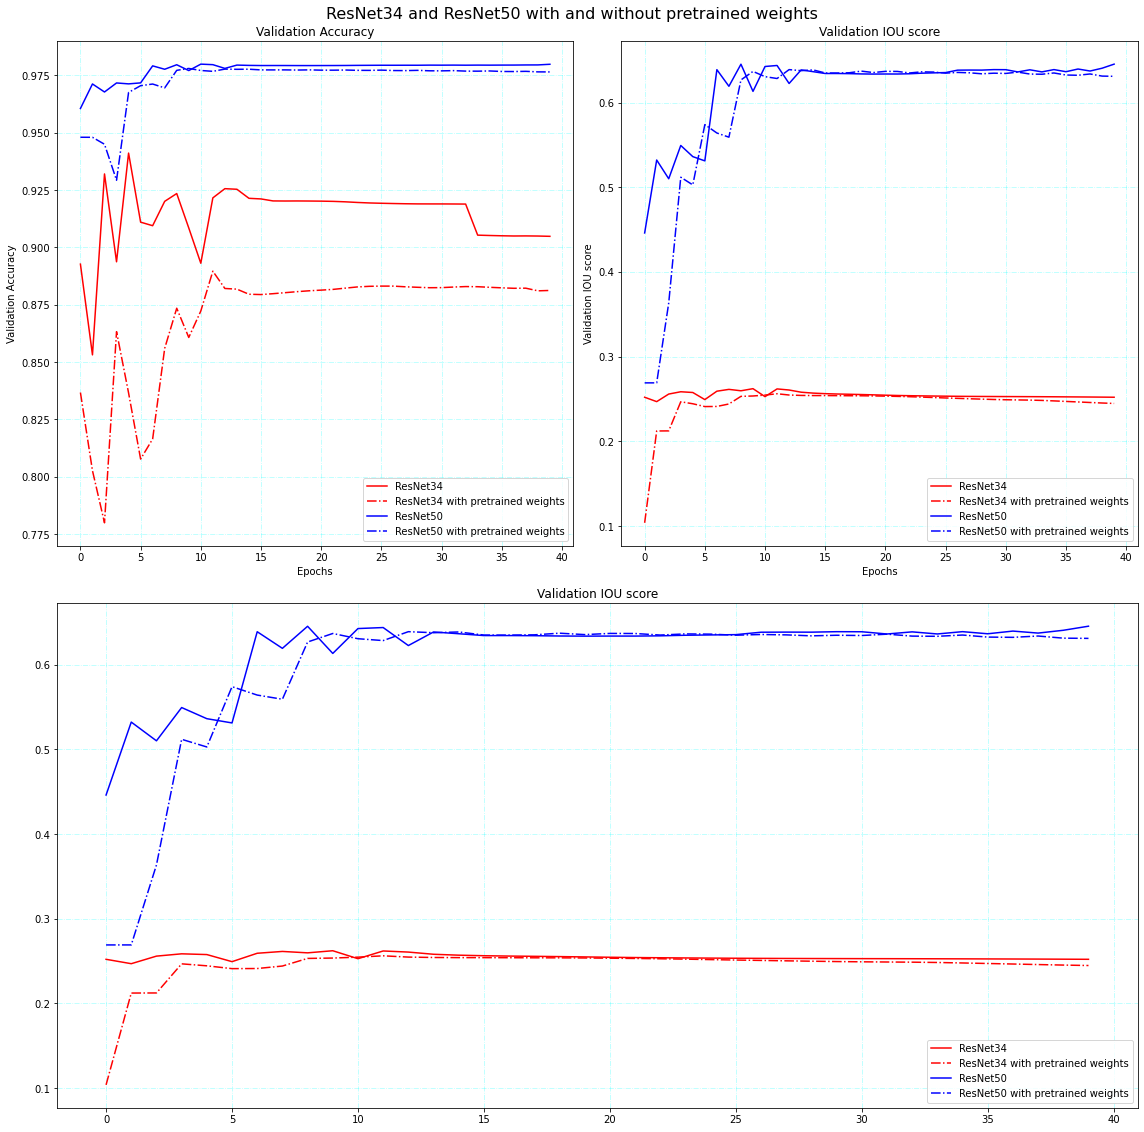

In [2]:
hist_resnet34wowt = pd.read_csv('saved_models/resnet34wowt/training_log/training_unet.csv')
hist_resnet34wt = pd.read_csv('saved_models/resnet34wtbs2/training_log/training_unet.csv')
hist_resnet50wowt = pd.read_csv('saved_models/ResNet50wowt/training_log/training_unet.csv')
hist_resnet50wt = pd.read_csv('saved_models/ResNet50/training_log/training_unet.csv')

#hist = hist_df
#epoch=range(len(hist_unet_do1))
fig = plt.figure(figsize=(16,16))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.plot(hist_resnet34wowt['val_accuracy'],'r',label='ResNet34')
ax1.plot(hist_resnet34wt['val_accuracy'],'-.r',label='ResNet34 with pretrained weights')
ax1.plot(hist_resnet50wowt['val_accuracy'],'b',label='ResNet50')
ax1.plot(hist_resnet50wt['val_accuracy'],'-.b',label='ResNet50 with pretrained weights')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Accuracy')
ax1.legend()

ax2.plot(hist_resnet34wowt['val_iou_score'],'r',label='ResNet34')
ax2.plot(hist_resnet34wt['val_iou_score'],'-.r',label='ResNet34 with pretrained weights')
ax2.plot(hist_resnet50wowt['val_iou_score'],'b',label='ResNet50')
ax2.plot(hist_resnet50wt['val_iou_score'],'-.b',label='ResNet50 with pretrained weights')
ax2.set_title('Validation IOU score')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation IOU score')
ax2.legend()

ax3.plot(hist_resnet34wowt['val_iou_score'],'r',label='ResNet34')
ax3.plot(hist_resnet34wt['val_iou_score'],'-.r',label='ResNet34 with pretrained weights')
ax3.plot(hist_resnet50wowt['val_iou_score'],'b',label='ResNet50')
ax3.plot(hist_resnet50wt['val_iou_score'],'-.b',label='ResNet50 with pretrained weights')
ax3.set_title('Validation IOU score')
ax3.legend()

plt.suptitle('ResNet34 and ResNet50 with and without pretrained weights', size=16)
ax1.grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax2.grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax3.grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Load model and test

In [42]:
from keras.models import load_model
model = load_model("resnet50wowt.hdf5", 
                      compile=False)

In [43]:
test_img_dir = "train_val_test/test/images/"
test_mask_dir = "train_val_test/test/masks/"

test_img_list=os.listdir(test_img_dir)
test_mask_list = os.listdir(test_mask_dir)
batch_size=1 
test_img_datagen = imageLoader(test_img_dir, test_img_list, 
                                test_mask_dir, test_mask_list, batch_size)


#### Mean IOU and IOU scores for each class (ResNet50 without pretrained weights)

In [44]:
from keras.metrics import MeanIoU
batch_size=1 
#test_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
for i in range(0,len(test_img_list)):
    test_image_batch, test_mask_batch = test_img_datagen.__next__()
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
    test_pred_batch = model.predict(test_image_batch, verbose =0)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)
    IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
    
mean_iou = IOU_keras.result().numpy()

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class0_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3]+ values[1,0]+ values[2,0]+ values[3,0])
class1_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3]+ values[0,1]+ values[2,1]+ values[3,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3]+ values[0,2]+ values[1,2]+ values[3,2])
class3_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2]+ values[0,3]+ values[1,3]+ values[2,3])
print('NOT tumor: {:.2f}%\nNECROTIC/CORE: {:.2f}%\nEDEMA: {:.2f}%\nENHANCING: {:.2f}%'.format(class0_IoU*100,class1_IoU*100, class2_IoU*100, class3_IoU*100))
print("Mean IoU =",(class0_IoU +class1_IoU+ class2_IoU+ class3_IoU)/4)

NOT tumor: 98.52%
NECROTIC/CORE: 48.97%
EDEMA: 57.42%
ENHANCING: 62.55%
Mean IoU = 0.668639600276947


### Prediction example

In [45]:
#Try images: 
img_num = 211

test_img = np.load("train_val_test/test/images/image_"+str(img_num)+".npy")

test_mask = np.load("train_val_test/test/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 0s 35ms/step


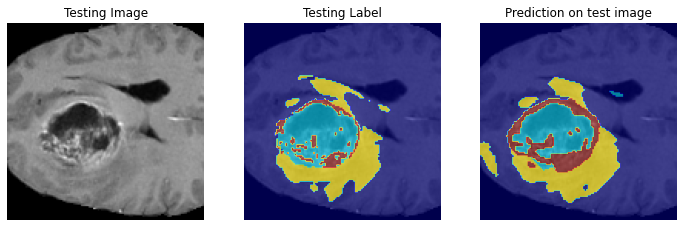

In [46]:
n_slice = 72
fig = plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.axis('off')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.imshow(test_mask_argmax[:,:,n_slice], cmap='jet',alpha=0.6)
plt.axis('off')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.imshow(test_prediction_argmax[:,:,n_slice], cmap='jet',alpha=0.6)
plt.axis('off')
plt.show()

In [ ]:
#Only for predicting
model.load_weights('saved_models/model_.05-0.416720.h5', compile=False)

In [ ]:
#For further training
model = load_model('saved_models/model_.05-0.416720.h5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5),
                                      'f1-score':sm.metrics.FScore(threshold=0.5)
                                     })